In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, jaccard_score, multilabel_confusion_matrix

## Getting Data From GDrive

In [0]:
import gdown
url = "https://drive.google.com/uc?export=download&confirm=g9sV&id=1YUeY8eO9h7kPZ8IebjSJwMTWXxSAWvcl"
gdown.download(url,'data.zip', quiet=False)
!unzip data.zip

Downloading...
From: https://drive.google.com/uc?export=download&confirm=g9sV&id=1YUeY8eO9h7kPZ8IebjSJwMTWXxSAWvcl
To: /content/data.zip
3.00GB [00:44, 67.1MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c275e1-e692-4445-bb4f-b740d117712f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c369ae-d8f9-4e44-b212-c6e2dc6ef580.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53

In [0]:
!mv A_05_Part_02_Dataset/Test A_05_Part_02_Dataset/unlabelled
print(os.listdir('A_05_Part_02_Dataset'))
!mkdir A_05_Part_02_Dataset/Test 
print(os.listdir('A_05_Part_02_Dataset'))
!mv A_05_Part_02_Dataset/unlabelled A_05_Part_02_Dataset/Test 
# !mkdir A_05_Part_02_Dataset/unlabelled
# !ls A_05_Part_02_Dataset/
# !cp -r A_05_Part_02_Dataset/Test/ A_05_Part_02_Dataset/unlabelled
# !mv A_05_Part_02_Dataset/unlabelled A_05_Part_02_Dataset/Test

['Train', 'Validation', 'unlabelled']
['Test', 'Train', 'Validation', 'unlabelled']


In [0]:
os.listdir('A_05_Part_02_Dataset')

['Test', 'Train', 'Validation']

In [0]:
os.listdir('A_05_Part_02_Dataset/Test')

['unlabelled']

In [0]:
os.listdir('A_05_Part_02_Dataset/Test/unlabelled/')

['570.png',
 '17.png',
 '362.png',
 '147.png',
 '583.png',
 '243.png',
 '86.png',
 '392.png',
 '300.png',
 '233.png',
 '561.png',
 '119.png',
 '49.png',
 '528.png',
 '138.png',
 '433.png',
 '259.png',
 '197.png',
 '463.png',
 '360.png',
 '440.png',
 '303.png',
 '482.png',
 '290.png',
 '500.png',
 '245.png',
 '405.png',
 '22.png',
 '484.png',
 '136.png',
 '604.png',
 '368.png',
 '620.png',
 '466.png',
 '619.png',
 '480.png',
 '611.png',
 '438.png',
 '319.png',
 '495.png',
 '331.png',
 '326.png',
 '512.jpg',
 '513.png',
 '352.png',
 '548.png',
 '452.png',
 '625.png',
 '444.png',
 '124.png',
 '164.png',
 '179.png',
 '0.png',
 '456.png',
 '16.png',
 '71.png',
 '355.png',
 '125.png',
 '447.png',
 '566.png',
 '589.png',
 '19.png',
 '143.png',
 '435.png',
 '510.png',
 '107.png',
 '77.png',
 '80.png',
 '576.png',
 '219.png',
 '256.png',
 '414.png',
 '194.png',
 '192.png',
 '544.png',
 '174.png',
 '551.png',
 '412.png',
 '262.png',
 '293.png',
 '253.png',
 '426.png',
 '475.png',
 '579.png',
 '5

### Loading Data

In [0]:
path = 'A_05_Part_02_Dataset/'
train_path = path + 'Train'
val_path = path + 'Validation'
test_path = path + 'Test'

In [0]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
val_data = datasets.ImageFolder(val_path, transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


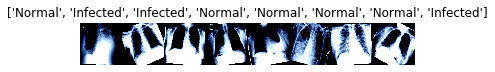

In [0]:
class_names = {0: 'Normal', 1: 'Infected'}
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    classes = classes.numpy()
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

## Choose Device

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def gpu_stats():
    f = torch.cuda.memory_summary(device=None, abbreviated=True)
    print(f)

def flush_gpu():
    global vgg16
    del(vgg16)
    torch.cuda.empty_cache()

## Class Weights

In [0]:
from collections import Counter
count = Counter(train_data.targets)
max_examples = max([v for k,v in count.items()])
class_weights = torch.tensor([max_examples/v for k,v in count.items()])
# class_weights = torch.ones(3)
print(count)
print(class_weights)
class_weights_cpu = class_weights.clone().cpu()
class_weights_gpu = class_weights.clone().to(device)

Counter({1: 4000, 2: 2000, 0: 200})
tensor([20.,  1.,  2.])


# Train Functions

In [0]:
def one_hot_encode(y, n_classes=3):
    y_new = torch.zeros((y.shape[0], n_classes))
    for idx, c_idx in enumerate(y):
        if c_idx == 0:
            y_new[idx,0] = 1
            y_new[idx,2] = 1
        else:
            y_new[idx, c_idx] = 1
    return y_new

def train(model, dataloader, criterion, optimizer, device, epoch):
    running_loss = 0.0
    model.train()    
    for i, data in enumerate(dataloader):    # train loop 
        # get the inputs
        inputs, labels = data
        labels = one_hot_encode(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        if i%50 == 0:
          print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(dataloader.dataset),
                  loss.item())) 
    return (running_loss/len(dataloader.dataset))*dataloader.batch_size

# Accuracy Utils

In [0]:
def collect_predictions(model, dataloader, device, use_sigmoid, num_classes=3, return_true_labels=True, return_numpy=True):
    predictions = torch.zeros((len(dataloader.dataset), num_classes)
                             , requires_grad=False)
    y_true = torch.zeros((len(dataloader.dataset), num_classes)
                         , requires_grad=False)
    assert predictions.is_cuda is False
    assert y_true.is_cuda is False
    batch_size = dataloader.batch_size
    model.eval()    
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        if use_sigmoid:
            outputs = torch.sigmoid(model(inputs)).detach().cpu()
        else:
            outputs = model(inputs).detach().cpu()
        predictions[i*batch_size:
                (i+1)*batch_size, ...] = outputs
        y_true[i*batch_size:
                (i+1)*batch_size, ...] = one_hot_encode(labels).detach().cpu()
    if return_numpy:
      predictions = predictions.detach().numpy()
      y_true = y_true.detach().numpy()
    else:
      predictions = predictions.detach()
      y_true = y_true.detach()
    if return_true_labels:
        return predictions, y_true
    else:
        return predictions


def accuracy(model, dataloader, device, use_sigmoid, threshold=0.5):
    preds, y_true = collect_predictions(model, dataloader, device, use_sigmoid)
    return accuracy_score(y_true, (preds > threshold))


def accuracy_and_loss(model, dataloader, criterion, device, use_sigmoid, threshold=0.5):
    preds, y_true = collect_predictions(model, dataloader, device, use_sigmoid, return_numpy=False)
    loss = criterion(preds, y_true)
    preds, y_true = preds.numpy(), y_true.numpy()
    acc = accuracy_score(y_true, (preds > threshold))
    return acc, loss.item()

def test_stats(model, dataloader, device, use_sigmoid, threshold=0.5):
    preds, y_true = collect_predictions(model, dataloader, device, use_sigmoid, return_numpy=False)
    # Covid accuracy
    covid_p, covid_y = preds[:,0], y_true[:,0]
    covid_accuracy = accuracy_score(covid_y, covid_p > threshold)
    # Pneumonia accuracy 
    pneum_p, pneum_y = preds[:,1], y_true[:,1]
    pneum_accuracy = accuracy_score(pneum_y, pneum_p > threshold)
    # Normal accuracy
    normal_p, normal_y = preds[:,2], y_true[:,2]
    normal_accuracy = accuracy_score(normal_y, normal_p > threshold)

    cf = multilabel_confusion_matrix(y_true, preds>threshold)
    js = jaccard_score(y_true, preds>threshold, average='samples')

    tn = cf[:, 0, 0]
    tp = cf[:, 1, 1]
    fn = cf[:, 1, 0]
    fp = cf[:, 0, 1]
    recall = tp / (tp + fn)
    precision = tn / (tn + fp)
    return [covid_accuracy, pneum_accuracy, normal_accuracy], recall, precision, cf, js

# Plot Utils

In [0]:
## Plotting functions

def sample_rgb():
    return (np.random.rand(),np.random.rand(),np.random.rand())

def line_plot(y, 
              x=None, 
              labels=None, 
              title=None, 
              xlabel=None, 
              ylabel=None,
              xlim=None,
              ylim=None,
              ax=None):
    """
    Args:
        y: List of numpy arrays
        x: Optional. Single list or numpy array for x-axis
        legend_labels: Optional. List of strings of same 
                        length as y. 
        title: Optional. Str. Figure Title.
        ax: Optional. Plots to this axis.
    """
    if ax is None:
        fig, ax = plt.subplots()

    if x is None:
        x = [np.arange(np.size(arr)) for arr in y]
    else:
        x_old = x.copy()
        x = [x_old for _ in range(len(y))]
    
    if labels is None:
        labels = [None]*len(y)
        
    for i, arr in enumerate(zip(x,y)):
        ax.plot(arr[0], 
                 arr[1], 
                 color=sample_rgb(), 
                 marker='o', 
                 linestyle='-',
                 linewidth=2,
                 markersize=12,
                 label=labels[i])
    
    plt.legend()
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
    if title is not None:
        ax.set_title(title)
    
    if xlim is not None:
        ax.set_xlim(xlim)
        
    if ylim is not None:
        ax.set_ylim(ylim)
    
    plt.show()
    
def plot_good_images(good_images):
    inp1 = good_images[0]
    inp2 = good_images[1]
    inp1 = inp1.numpy().transpose((1, 2, 0))
    inp2 = inp2.numpy().transpose((1, 2, 0))
    
    fig, ax = plt.subplots(1,2)
    plt.axis('off')
    ax[0].imshow(inp1)
    ax[1].imshow(inp2)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title('Normal classified as normal.')
    ax[1].set_title('Infected classified as infected.')

def plot_bad_images(bad_images):
    inp1 = bad_images[0]
    inp2 = bad_images[1]
    inp1 = inp1.numpy().transpose((1, 2, 0))
    inp2 = inp2.numpy().transpose((1, 2, 0))
    
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(inp1)
    ax[1].imshow(inp2)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title('Normal classified as infected.')
    ax[1].set_title('Infected classified as normal.')

# Focal Loss Class


In [0]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, pos_weights=None):
        super().__init__()
        self.gamma = gamma
        if pos_weights is not None: 
            self.pos_weights = pos_weights[None,...]
            assert(self.pos_weights.is_cuda == pos_weights.is_cuda)
        else:
            self.pos_weights = None

    def forward(self, out, labels):
        labels_c = (labels == 0).float()
        p_t = (labels_c - out)*(labels*(-2)+1)
        FL = -(1-p_t)**self.gamma*torch.log(p_t + 1e-20)
        if self.pos_weights is not None:
            FL = self.pos_weights*FL
        FL = (FL.mean(dim=-1).mean())
        return FL

# VGG-16

## Binary Cross Entropy

### With Class Balancing

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

num_features = vgg16.classifier[0].in_features

# for param in vgg16.parameters():         # Freeze all conv layers
#     param.requires_grad = False

roll_no = 1
num_classes = 3

features = [nn.Linear(num_features, roll_no*10+100), 
            nn.ReLU(inplace=True), 
            nn.Dropout(p=0.5, inplace=False), 
            nn.Linear(roll_no*10+100, num_classes)]
vgg16.classifier = nn.Sequential(*features)
vgg16.to(device)
print()

In [0]:
os.mkdir('BCE')

FileExistsError: ignored

In [0]:
BATCH_SIZE = 8
Epochs = 10
criterion_cpu = nn.BCEWithLogitsLoss()
criterion_gpu = nn.BCEWithLogitsLoss()
# assert criterion_cpu.pos_weight.is_cuda is False
# assert criterion_gpu.pos_weight.is_cuda is True
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(vgg16, trainloader, criterion_cpu, device, use_sigmoid=True)
val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion_cpu, device, use_sigmoid=True)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(vgg16, trainloader, criterion_gpu, optimizer, device, epoch)
    train_acc = accuracy(vgg16, trainloader, device, use_sigmoid=True)
    val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion_cpu, device, use_sigmoid=True)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(vgg16.state_dict(), './BCE/vgg16_FC_Only.pth')

np.save('./BCE/vgg_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./BCE/vgg_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./BCE/vgg_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./BCE/vgg_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.8029	        Training Accuracy: 0.07	        Validation Loss: 0.7987	        Validation Accuracy: 0.11	
Train Epoch: 0 [0/6200]	Loss: 0.725821
Train Epoch: 0 [400/6200]	Loss: 0.695585
Train Epoch: 0 [800/6200]	Loss: 0.130309
Train Epoch: 0 [1200/6200]	Loss: 0.139159
Train Epoch: 0 [1600/6200]	Loss: 0.218844
Train Epoch: 0 [2000/6200]	Loss: 0.050590
Train Epoch: 0 [2400/6200]	Loss: 0.086369
Train Epoch: 0 [2800/6200]	Loss: 0.154518
Train Epoch: 0 [3200/6200]	Loss: 0.096829
Train Epoch: 0 [3600/6200]	Loss: 0.144265
Train Epoch: 0 [4000/6200]	Loss: 0.084318
Train Epoch: 0 [4400/6200]	Loss: 0.168428
Train Epoch: 0 [4800/6200]	Loss: 0.247191
Train Epoch: 0 [5200/6200]	Loss: 0.212072
Train Epoch: 0 [5600/6200]	Loss: 0.008577
Train Epoch: 0 [6000/6200]	Loss: 0.129456
Epoch  0 	            Training Loss: 0.2559	            Training Accuracy: 0.86	            Validation Loss: 0.6073	            Validation Accuracy: 0.90	
Train Epoch: 1 [0/6200]	Loss: 0.239179
Train Epoch: 1 [40

KeyboardInterrupt: ignored

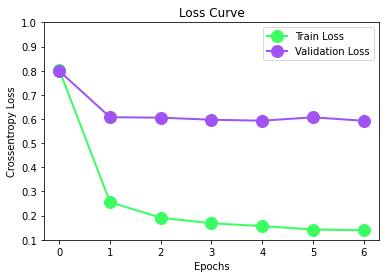

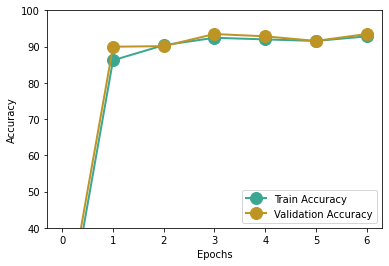

*************** Training Data ***************
Accuracy  [0.985, 0.9414516129032258, 0.9412903225806452]
Recall  [0.595  0.9965 0.84  ]
Precision  [0.998      0.84136364 0.997     ]
Jaccard Score  0.9367741935483871
Confusion Matrix  [[[5988   12]
  [  81  119]]

 [[1851  349]
  [  14 3986]]

 [[3988   12]
  [ 352 1848]]]
*************** Validation Data ***************
Accuracy  [0.9745222929936306, 0.9378980891719745, 0.9378980891719745]
Recall  [0.42857143 0.995      0.8377193 ]
Precision  [1.        0.8377193 0.995    ]
Jaccard Score  0.9347133757961783
Confusion Matrix  [[[600   0]
  [ 16  12]]

 [[191  37]
  [  2 398]]

 [[398   2]
  [ 37 191]]]


In [0]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(7),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.1,1.0],
          title='Loss Curve')

line_plot([np.array(train_acc_arr)*100, 
           np.array(val_acc_arr)*100], 
          x = np.arange(7),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)

# load the best model 
vgg16.state_dict = torch.load('./BCE/vgg16_FC_Only.pth')
print("*"*15 + " Training Data " + "*"*15)
accuracy_arr, recall, precision, cf, js = test_stats(vgg16, trainloader, device, use_sigmoid=True)
print("Accuracy ", accuracy_arr)
print("Recall ", recall)
print("Precision ", precision)
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)
print("*"*15 + " Validation Data " + "*"*15)
accuracy_arr, recall, precision, cf, js = test_stats(vgg16, valloader, device, use_sigmoid=True)
print("Accuracy ", accuracy_arr)
print("Recall ", recall)
print("Precision ", precision)
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)

## With Focal Loss

### Without Class Balancing

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

num_features = vgg16.classifier[0].in_features

# for param in vgg16.parameters():         # Freeze all conv layers
#     param.requires_grad = False

roll_no = 1
num_classes = 3

features = [nn.Linear(num_features, roll_no*10+100), 
            nn.ReLU(inplace=True), 
            nn.Dropout(p=0.5, inplace=False), 
            nn.Linear(roll_no*10+100, num_classes),
            nn.Sigmoid()]
vgg16.classifier = nn.Sequential(*features)

vgg16.to(device)
print()
        
BATCH_SIZE = 8
Epochs = 10
criterion_gpu = FocalLoss(gamma=2)
criterion = FocalLoss(gamma=2)
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
os.mkdir('focal_loss')

In [0]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(vgg16, trainloader, criterion, device, use_sigmoid=False)
val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion, device, use_sigmoid=False)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(vgg16, trainloader, criterion_gpu, optimizer, device, epoch)
    train_acc = accuracy(vgg16, trainloader, device, use_sigmoid=False)
    val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion, device, use_sigmoid=False)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(vgg16.state_dict(), './focal_loss/vgg16_FC_Only.pth')

np.save('./focal_loss/vgg_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./focal_loss/vgg_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./focal_loss/vgg_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./focal_loss/vgg_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.1854	        Training Accuracy: 0.14	        Validation Loss: 0.1975	        Validation Accuracy: 0.09	
Train Epoch: 0 [0/6200]	Loss: 0.202298
Train Epoch: 0 [400/6200]	Loss: 0.109150
Train Epoch: 0 [800/6200]	Loss: 0.117021
Train Epoch: 0 [1200/6200]	Loss: 0.124701
Train Epoch: 0 [1600/6200]	Loss: 0.117208
Train Epoch: 0 [2000/6200]	Loss: 0.219100
Train Epoch: 0 [2400/6200]	Loss: 0.128990
Train Epoch: 0 [2800/6200]	Loss: 0.138111
Train Epoch: 0 [3200/6200]	Loss: 0.124668
Train Epoch: 0 [3600/6200]	Loss: 0.170292
Train Epoch: 0 [4000/6200]	Loss: 0.108608
Train Epoch: 0 [4400/6200]	Loss: 0.128286
Train Epoch: 0 [4800/6200]	Loss: 0.130043
Train Epoch: 0 [5200/6200]	Loss: 0.153768
Train Epoch: 0 [5600/6200]	Loss: 0.130423
Train Epoch: 0 [6000/6200]	Loss: 0.103075
Epoch  0 	            Training Loss: 0.1328	            Training Accuracy: 0.65	            Validation Loss: 0.1299	            Validation Accuracy: 0.64	
Train Epoch: 1 [0/6200]	Loss: 0.112170
Train Epoch: 1 [40

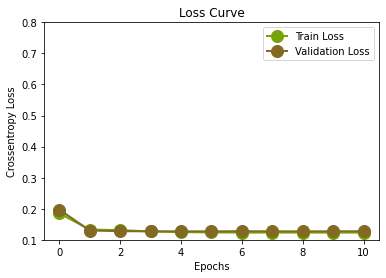

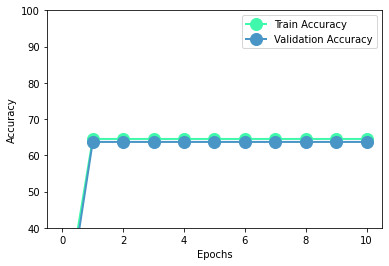

*************** Training Data ***************
Accuracy  [0.967741935483871, 0.6451612903225806, 0.6451612903225806]
Recall  [0. 1. 0.]
Precision  [1. 0. 1.]
F1  0.0
Jaccard Score  0.6451612903225806
Confusion Matrix  [[[6000    0]
  [ 200    0]]

 [[   0 2200]
  [   0 4000]]

 [[4000    0]
  [2200    0]]]
*************** Validation Data ***************
Accuracy  [0.9554140127388535, 0.6369426751592356, 0.6369426751592356]
Recall  [0. 1. 0.]
Precision  [1. 0. 1.]
F1  0.0
Jaccard Score  0.6369426751592356
Confusion Matrix  [[[600   0]
  [ 28   0]]

 [[  0 228]
  [  0 400]]

 [[400   0]
  [228   0]]]


In [0]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(11),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.1,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr)*100, 
           np.array(val_acc_arr)*100], 
          x = np.arange(11),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)

# load the best model 
vgg16.state_dict = torch.load('./focal_loss/vgg16_FC_Only.pth')
print("*"*15 + " Training Data " + "*"*15)
accuracy_arr, recall, precision, cf, js = test_stats(vgg16, trainloader, device, use_sigmoid=False)
print("Accuracy ", accuracy_arr)
print("Recall ", recall)
print("Precision ", precision)
print("F1 ", np.mean((2*precision*recall)/(precision+recall)))
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)
print("*"*15 + " Validation Data " + "*"*15)
accuracy_arr, recall, precision, cf, js = test_stats(vgg16, valloader, device, use_sigmoid=False)
print("Accuracy ", accuracy_arr)
print("Recall ", recall)
print("Precision ", precision)
print("F1 ", np.mean((2*precision*recall)/(precision+recall)))
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)

# Res Net 18

## With Focal Loss

In [0]:
resnet18 = models.resnet18(pretrained=True)

num_features = resnet18.fc.in_features

roll_no = 1
num_classes = 3

features = [nn.Linear(num_features, roll_no*10+100), 
            nn.ReLU(inplace=True), 
            nn.Linear(roll_no*10+100, num_classes),
            nn.Sigmoid()]
resnet18.fc = nn.Sequential(*features)

BATCH_SIZE = 8
Epochs = 10

criterion_gpu = FocalLoss(gamma=2, pos_weights=class_weights_gpu)
criterion = FocalLoss(gamma=2, pos_weights=class_weights_cpu)

optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(resnet18, trainloader, criterion, device, use_sigmoid=False)
val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device, use_sigmoid=False)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(resnet18, trainloader, criterion_gpu, optimizer, device, epoch)
    train_acc = accuracy(resnet18, trainloader, device, use_sigmoid=False)
    val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device, use_sigmoid=False)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(resnet18.state_dict(), './focal_loss/resnet18_FC_Only.pth')

np.save('./focal_loss/resnet18_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./focal_loss/resnet18_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./focal_loss/resnet18_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./focal_loss/resnet18_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 1.8008	        Training Accuracy: 0.00	        Validation Loss: 1.4437	        Validation Accuracy: 0.00	
Train Epoch: 0 [0/6200]	Loss: 1.102619
Train Epoch: 0 [400/6200]	Loss: 0.249051
Train Epoch: 0 [800/6200]	Loss: 0.760514
Train Epoch: 0 [1200/6200]	Loss: 0.201244
Train Epoch: 0 [1600/6200]	Loss: 0.255773
Train Epoch: 0 [2000/6200]	Loss: 2.100737
Train Epoch: 0 [2400/6200]	Loss: 0.110860
Train Epoch: 0 [2800/6200]	Loss: 0.082967
Train Epoch: 0 [3200/6200]	Loss: 0.513193
Train Epoch: 0 [3600/6200]	Loss: 0.094191
Train Epoch: 0 [4000/6200]	Loss: 0.055086
Train Epoch: 0 [4400/6200]	Loss: 0.098052
Train Epoch: 0 [4800/6200]	Loss: 0.164261
Train Epoch: 0 [5200/6200]	Loss: 0.150210
Train Epoch: 0 [5600/6200]	Loss: 0.062840
Train Epoch: 0 [6000/6200]	Loss: 0.151922
Epoch  0 	            Training Loss: 0.3109	            Training Accuracy: 0.86	            Validation Loss: 0.2530	            Validation Accuracy: 0.87	
Train Epoch: 1 [0/6200]	Loss: 0.243604
Train Epoch: 1 [40

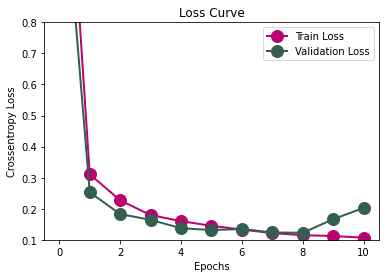

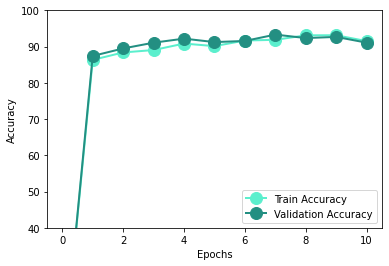

In [0]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(11),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.1,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr)*100, 
           np.array(val_acc_arr)*100], 
          x = np.arange(11),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)

In [0]:
# load the best model 
resnet18.state_dict = torch.load('./focal_loss/resnet18_FC_Only.pth')
print("*"*15 + " Training Data " + "*"*15)
accuracy, recall, precision, cf, js = test_stats(resnet18, trainloader, device, use_sigmoid=False)
print("Accuracy ", accuracy)
print("Recall ", recall)
print("Precision ", precision)
print("F1 ", np.mean((2*precision*recall)/(precision+recall)))
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)
print("*"*15 + " Validation Data " + "*"*15)
accuracy, recall, precision, cf, js = test_stats(resnet18, valloader, device, use_sigmoid=False)
print("Accuracy ", accuracy)
print("Recall ", recall)
print("Precision ", precision)
print("F1 ", np.mean((2*precision*recall)/(precision+recall)))
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)

*************** Training Data ***************
Accuracy  [0.9806451612903225, 0.9329032258064516, 0.9320967741935484]
Recall  [0.965      0.9485     0.90318182]
Precision  [0.98116667 0.90454545 0.948     ]
F1  0.9413553268102745
Jaccard Score  0.9256182795698926
Confusion Matrix  [[[5887  113]
  [   7  193]]

 [[1990  210]
  [ 206 3794]]

 [[3792  208]
  [ 213 1987]]]
*************** Validation Data ***************
Accuracy  [0.9633757961783439, 0.9347133757961783, 0.9315286624203821]
Recall  [0.82142857 0.9575     0.89035088]
Precision  [0.97       0.89473684 0.955     ]
F1  0.9120504930151222
Jaccard Score  0.9219745222929936
Confusion Matrix  [[[582  18]
  [  5  23]]

 [[204  24]
  [ 17 383]]

 [[382  18]
  [ 25 203]]]


## Binary Cross Entropy

### With Class Balancing

In [0]:
resnet18 = models.resnet18(pretrained=True)

num_features = resnet18.fc.in_features

roll_no = 1
num_classes = 3

features = [nn.Linear(num_features, roll_no*10+100), 
            nn.ReLU(inplace=True), 
            nn.Linear(roll_no*10+100, num_classes)]
resnet18.fc = nn.Sequential(*features)

BATCH_SIZE = 8
Epochs = 10

criterion_gpu = nn.BCEWithLogitsLoss(pos_weight=class_weights_gpu)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_cpu)

optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
# print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(resnet18, trainloader, criterion, device, use_sigmoid=True)
val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device, use_sigmoid=True)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(resnet18, trainloader, criterion_gpu, optimizer, device, epoch)
    train_acc = accuracy(resnet18, trainloader, device, use_sigmoid=True)
    val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device, use_sigmoid=True)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(resnet18.state_dict(), './BCE/resnet18_FC_Only.pth')

np.save('./BCE/resnet18_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./BCE/resnet18_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./BCE/resnet18_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./BCE/resnet18_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.9501	        Training Accuracy: 0.50	        Validation Loss: 0.9898	        Validation Accuracy: 0.31	
Train Epoch: 0 [0/6200]	Loss: 0.648062
Train Epoch: 0 [400/6200]	Loss: 0.552510
Train Epoch: 0 [800/6200]	Loss: 0.657008
Train Epoch: 0 [1200/6200]	Loss: 1.682946
Train Epoch: 0 [1600/6200]	Loss: 0.252323
Train Epoch: 0 [2000/6200]	Loss: 0.733982
Train Epoch: 0 [2400/6200]	Loss: 1.281778
Train Epoch: 0 [2800/6200]	Loss: 0.481825
Train Epoch: 0 [3200/6200]	Loss: 0.323398
Train Epoch: 0 [3600/6200]	Loss: 0.455693
Train Epoch: 0 [4000/6200]	Loss: 0.706944
Train Epoch: 0 [4400/6200]	Loss: 0.155615
Train Epoch: 0 [4800/6200]	Loss: 0.227749
Train Epoch: 0 [5200/6200]	Loss: 0.260904
Train Epoch: 0 [5600/6200]	Loss: 0.222653
Train Epoch: 0 [6000/6200]	Loss: 0.324099
Epoch  0 	            Training Loss: 0.5871	            Training Accuracy: 0.82	            Validation Loss: 0.7991	            Validation Accuracy: 0.86	
Train Epoch: 1 [0/6200]	Loss: 0.248220
Train Epoch: 1 [40

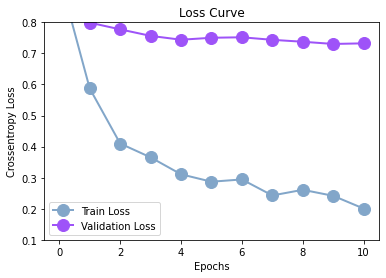

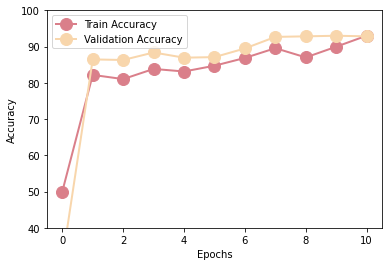

*************** Training Data ***************
Accuracy  [0.9830645161290322, 0.9530645161290323, 0.9479032258064516]
Recall  [0.99   0.9825 0.92  ]
Precision  [0.98283333 0.89954545 0.96325   ]
Jaccard Score  0.944005376344086
Confusion Matrix  [[[5897  103]
  [   2  198]]

 [[1979  221]
  [  70 3930]]

 [[3853  147]
  [ 176 2024]]]
*************** Validation Data ***************
Accuracy  [0.9840764331210191, 0.9490445859872612, 0.9442675159235668]
Recall  [0.92857143 0.98       0.90789474]
Precision  [0.98666667 0.89473684 0.965     ]
Jaccard Score  0.942144373673036
Confusion Matrix  [[[592   8]
  [  2  26]]

 [[204  24]
  [  8 392]]

 [[386  14]
  [ 21 207]]]


In [0]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(11),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.1,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr)*100, 
           np.array(val_acc_arr)*100], 
          x = np.arange(11),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)


# load the best model 
resnet18.state_dict = torch.load('./BCE/resnet18_FC_Only.pth')
print("*"*15 + " Training Data " + "*"*15)
accuracy_arr, recall, precision, cf, js = test_stats(resnet18, trainloader, device, use_sigmoid=True)
print("Accuracy ", accuracy_arr)
print("Recall ", recall)
print("Precision ", precision)
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)
print("*"*15 + " Validation Data " + "*"*15)
accuracy_arr, recall, precision, cf, js = test_stats(resnet18, valloader, device, use_sigmoid=True)
print("Accuracy ", accuracy_arr)
print("Recall ", recall)
print("Precision ", precision)
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)

### Without Class Balancing

In [0]:
resnet18 = models.resnet18(pretrained=True)

num_features = resnet18.fc.in_features

roll_no = 1
num_classes = 3

features = [nn.Linear(num_features, roll_no*10+100), 
            nn.ReLU(inplace=True), 
            nn.Linear(roll_no*10+100, num_classes)]
resnet18.fc = nn.Sequential(*features)

BATCH_SIZE = 8
Epochs = 10

criterion_gpu = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
# print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
os.mkdir('BCE_no_alpha')

In [0]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(resnet18, trainloader, criterion, device, use_sigmoid=True)
val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device, use_sigmoid=True)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(resnet18, trainloader, criterion_gpu, optimizer, device, epoch)
    train_acc = accuracy(resnet18, trainloader, device, use_sigmoid=True)
    val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device, use_sigmoid=True)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(resnet18.state_dict(), './BCE_no_alpha/resnet18_FC_Only.pth')

np.save('./BCE_no_alpha/resnet18_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./BCE_no_alpha/resnet18_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./BCE_no_alpha/resnet18_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./BCE_no_alpha/resnet18_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.8106	        Training Accuracy: 0.14	        Validation Loss: 0.8162	        Validation Accuracy: 0.06	
Train Epoch: 0 [0/6200]	Loss: 0.752795
Train Epoch: 0 [400/6200]	Loss: 0.377831
Train Epoch: 0 [800/6200]	Loss: 0.524332
Train Epoch: 0 [1200/6200]	Loss: 0.428339
Train Epoch: 0 [1600/6200]	Loss: 0.246300
Train Epoch: 0 [2000/6200]	Loss: 0.351074
Train Epoch: 0 [2400/6200]	Loss: 0.148435
Train Epoch: 0 [2800/6200]	Loss: 0.457258
Train Epoch: 0 [3200/6200]	Loss: 0.373257
Train Epoch: 0 [3600/6200]	Loss: 0.090256
Train Epoch: 0 [4000/6200]	Loss: 0.372338
Train Epoch: 0 [4400/6200]	Loss: 0.209912
Train Epoch: 0 [4800/6200]	Loss: 0.256672
Train Epoch: 0 [5200/6200]	Loss: 0.226505
Train Epoch: 0 [5600/6200]	Loss: 0.303422
Train Epoch: 0 [6000/6200]	Loss: 0.307171
Epoch  0 	            Training Loss: 0.3125	            Training Accuracy: 0.88	            Validation Loss: 0.6068	            Validation Accuracy: 0.89	
Train Epoch: 1 [0/6200]	Loss: 0.211837
Train Epoch: 1 [40

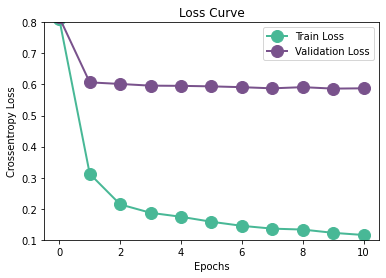

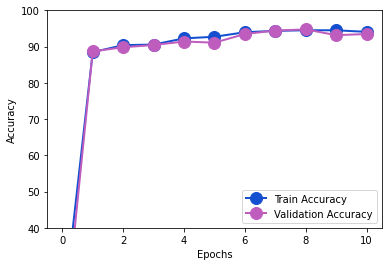

*************** Training Data ***************
Accuracy  [0.9896774193548387, 0.9491935483870968, 0.9490322580645161]
Recall  [0.785      0.9515     0.94363636]
Precision  [0.9965 0.945  0.952 ]
Jaccard Score  0.944274193548387
Confusion Matrix  [[[5979   21]
  [  43  157]]

 [[2079  121]
  [ 194 3806]]

 [[3808  192]
  [ 124 2076]]]
*************** Validation Data ***************
Accuracy  [0.9890322580645161, 0.9519354838709677, 0.9514516129032258]
Recall  [0.77       0.95925    0.93818182]
Precision  [0.99633333 0.93863636 0.95875   ]
Jaccard Score  0.9466935483870967
Confusion Matrix  [[[5978   22]
  [  46  154]]

 [[2065  135]
  [ 163 3837]]

 [[3835  165]
  [ 136 2064]]]


In [0]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(11),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.1,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr)*100, 
           np.array(val_acc_arr)*100], 
          x = np.arange(11),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)


# load the best model 
resnet18.state_dict = torch.load('./BCE_no_alpha/resnet18_FC_Only.pth')
print("*"*15 + " Training Data " + "*"*15)
accuracy_arr, recall, precision, cf, js = test_stats(resnet18, trainloader, device, use_sigmoid=True)
print("Accuracy ", accuracy_arr)
print("Recall ", recall)
print("Precision ", precision)
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)
print("*"*15 + " Validation Data " + "*"*15)
accuracy_arr, recall, precision, cf, js = test_stats(resnet18, trainloader, device, use_sigmoid=True)
print("Accuracy ", accuracy_arr)
print("Recall ", recall)
print("Precision ", precision)
print("Jaccard Score ", js)
print("Confusion Matrix ", cf)

# Making Predictions

In [0]:
test_data = datasets.ImageFolder(test_path, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [0]:
def create_csv(model, dataloader, device, use_sigmoid, csv_file):
    with open(csv_file, 'w+') as fopen:
      for i, data in enumerate(dataloader):
          x, _ = data
          x = x.to(device)
          if use_sigmoid:
              y = torch.sigmoid(model(x)).detach().cpu()
          else:
              y = model(x).detach().cpu() 
          y = (y > 0.5).int()
          img_name = dataloader.dataset.samples[i][0].split("/")[-1]
          line = img_name + "," + str(y[0,0].item()) + "," + str(y[0,2].item()) + "," + str(y[0,1].item()) +'\n'
          fopen.write(line)

In [0]:
create_csv(resnet18, testloader, device, use_sigmoid=True, csv_file='resnet_bce_with_balancing.csv')

In [0]:
with open('resnet_bce_with_alpha.csv', 'r') as file:
  print(file.readlines())

['0,0,0,1\n', '1,0,0,1\n', '10,0,0,1\n', '100,0,1,0\n', '101,0,0,1\n', '102,0,0,1\n', '103,0,0,1\n', '104,0,0,1\n', '105,1,1,0\n', '106,0,0,1\n', '107,0,0,1\n', '108,0,1,0\n', '109,0,0,1\n', '11,0,0,1\n', '110,0,1,0\n', '111,0,1,0\n', '112,0,0,1\n', '113,0,0,1\n', '114,0,1,0\n', '115,0,1,0\n', '116,0,0,1\n', '117,0,0,1\n', '118,0,0,1\n', '119,0,1,0\n', '12,0,0,1\n', '120,1,1,0\n', '121,0,0,1\n', '122,0,1,1\n', '123,0,0,1\n', '124,0,1,0\n', '125,0,0,1\n', '126,0,0,1\n', '127,0,0,1\n', '128,0,0,1\n', '129,0,0,1\n', '13,0,1,0\n', '130,0,0,1\n', '131,0,1,1\n', '132,0,1,0\n', '133,0,0,1\n', '134,0,0,1\n', '135,1,1,0\n', '136,1,1,0\n', '137,0,0,1\n', '138,0,1,0\n', '139,0,0,1\n', '14,0,0,1\n', '140,0,0,1\n', '141,0,0,1\n', '142,0,0,1\n', '143,0,0,1\n', '144,0,0,1\n', '145,0,1,0\n', '146,0,0,1\n', '147,0,1,0\n', '148,0,0,1\n', '149,1,1,0\n', '15,0,1,0\n', '150,0,1,0\n', '151,0,0,1\n', '152,0,1,0\n', '153,0,0,1\n', '154,0,0,1\n', '155,0,0,1\n', '156,0,0,1\n', '157,0,0,1\n', '158,0,0,1\n', '159

In [64]:
!zip -r BCE.zip BCE
from google.colab import files
files.download('BCE.zip')

  adding: BCE/ (stored 0%)
  adding: BCE/resnet18_train_loss_arr.npy (deflated 25%)
  adding: BCE/vgg16_FC_Only.pth (deflated 7%)
  adding: BCE/resnet18_val_loss_arr.npy (deflated 40%)
  adding: BCE/resnet18_train_acc_arr.npy (deflated 27%)
  adding: BCE/resnet18_val_acc_arr.npy (deflated 30%)
  adding: BCE/resnet18_FC_Only.pth (deflated 7%)


KeyboardInterrupt: ignored

In [0]:
!zip -r focal_loss.zip focal_loss
files.download('focal_loss.zip')

  adding: focal_loss/ (stored 0%)
  adding: focal_loss/vgg_val_acc_arr.npy (deflated 59%)
  adding: focal_loss/resnet18_train_loss_arr.npy (deflated 25%)
  adding: focal_loss/vgg16_FC_Only.pth (deflated 7%)
  adding: focal_loss/vgg_train_loss_arr.npy (deflated 27%)
  adding: focal_loss/vgg_val_loss_arr.npy (deflated 42%)
  adding: focal_loss/resnet18_val_loss_arr.npy (deflated 39%)
  adding: focal_loss/resnet18_train_acc_arr.npy (deflated 25%)
  adding: focal_loss/resnet18_val_acc_arr.npy (deflated 33%)
  adding: focal_loss/resnet18_FC_Only.pth (deflated 7%)
  adding: focal_loss/vgg_train_acc_arr.npy (deflated 60%)


----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 54014, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil